<a href="https://colab.research.google.com/github/claudio1975/Medium-blog/blob/master/CLV_Conformal_Prediction_Segmentation/CLV_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare Workspace

In [1]:
! pip install shap &> /dev/null

In [2]:
! pip install feature_engine &>/dev/null

In [3]:
! pip install optuna &>/dev/null

In [4]:
! pip install MAPIE &>/dev/null

In [5]:
! pip install scikit-learn-extra &>/dev/null

In [6]:
! pip install dtaidistance &>/dev/null

In [7]:
! pip install gower &>/dev/null

In [8]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import scipy
from scipy.stats import shapiro
import scipy.stats as stats
import feature_engine
from feature_engine.timeseries.forecasting import WindowFeatures
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.linear_model import TweedieRegressor
import lightgbm
import xgboost
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import mapie
from mapie.metrics import (coverage_width_based, regression_coverage_score,
                           regression_mean_width_score)
from mapie.regression import MapieTimeSeriesRegressor
from mapie.subsample import BlockBootstrap
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_squared_error
import statsmodels
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
import gower
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
import dtaidistance
from dtaidistance import dtw
from sklearn.manifold import Isomap
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import optuna
import shap


import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [9]:
np.__version__

'1.26.4'

In [10]:
pd.__version__

'2.2.2'

In [11]:
matplotlib.__version__

'3.8.0'

In [12]:
sns.__version__

'0.13.2'

In [13]:
scipy.__version__

'1.13.1'

In [14]:
feature_engine.__version__

'1.8.1'

In [15]:
sklearn.__version__

'1.5.2'

In [16]:
lightgbm.__version__

'4.5.0'

In [17]:
xgboost.__version__

'2.1.2'

In [18]:
mapie.__version__

'0.9.1'

In [19]:
statsmodels.__version__

'0.14.4'

In [20]:
dtaidistance.__version__

'2.3.12'

In [21]:
optuna.__version__

'4.0.0'

In [22]:
shap.__version__

'0.46.0'

### Upload Dataset

In [23]:
# dataset
df_0=pd.read_csv('/content/AutoInsurance.csv',index_col=0)

### Data set Overview

In [24]:
# Dimensions of data set
print(df_0.shape)

(9134, 23)


In [25]:
# List types for each attribute
print(df_0.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9134 entries, BU79786 to Y167826
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   State                          9134 non-null   object 
 1   Customer Lifetime Value        9134 non-null   float64
 2   Response                       9134 non-null   object 
 3   Coverage                       9134 non-null   object 
 4   Education                      9134 non-null   object 
 5   Effective To Date              9134 non-null   object 
 6   EmploymentStatus               9134 non-null   object 
 7   Gender                         9134 non-null   object 
 8   Income                         9134 non-null   int64  
 9   Location Code                  9134 non-null   object 
 10  Marital Status                 9134 non-null   object 
 11  Monthly Premium Auto           9134 non-null   int64  
 12  Months Since Last Claim        9134 non-null

In [26]:
# look at the columns
print(df_0.columns)

Index(['State', 'Customer Lifetime Value', 'Response', 'Coverage', 'Education',
       'Effective To Date', 'EmploymentStatus', 'Gender', 'Income',
       'Location Code', 'Marital Status', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Policy Type',
       'Policy', 'Renew Offer Type', 'Sales Channel', 'Total Claim Amount',
       'Vehicle Class', 'Vehicle Size'],
      dtype='object')


In [27]:
# Take a peek at the first rows of the data
df_0.head()

,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
Customer,,,,,,,,,,,,,,,,,,,,,
BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
HB64268,Washington,2813.692575,No,Basic,Bachelor,3/2/2011,Employed,M,43836,Rural,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


### Data Cleaning & Summary Statistics

In [28]:
# Cast datetime variable in datetime format
df_1 = df_0.copy()
# Reset index to bring `Customer` into the columns
df_1 = df_1.reset_index()
df_1['Effective_Date'] = pd.to_datetime(df_1['Effective To Date'])
df_1 = df_1.sort_values(by='Effective_Date')
# Sanity check: data span
df_1.Effective_Date.min(), df_1.Effective_Date.max()


(Timestamp('2011-01-01 00:00:00'), Timestamp('2011-12-02 00:00:00'))

### Handling Missing Values

In [29]:
# Check missing values both to numeric features and categorical features
missing = df_1.isnull().sum()/df_1.shape[0]*100
missing

,0
Customer,0.0
State,0.0
Customer Lifetime Value,0.0
Response,0.0
Coverage,0.0
Education,0.0
Effective To Date,0.0
EmploymentStatus,0.0
Gender,0.0
Income,0.0


In [30]:
# Check for duplicates in the 'Customer' column
df_1_duplicates = df_1[df_1.duplicated(['Customer'])]

In [31]:
df_1_duplicates

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Effective_Date


In [32]:
df_1 = df_1.drop(['Customer','Effective To Date'], axis=1)


In [33]:
# Rename some features for a practical use
df_2 = df_1.copy()
df_2 = df_2.rename(columns={"Customer Lifetime Value":"Customer_Lifetime_Value","Location Code":"Location_Code","Marital Status":"Marital_Status","Monthly Premium Auto":"Monthly_Premium_Auto","Months Since Last Claim":"Months_Since_Last_Claim",
                           "Months Since Policy Inception":"Months_Since_Policy_Inception","Number of Open Complaints":"Number_of_Open_Complaints","Number of Policies":"Number_of_Policies",
                           "Policy Type":"Policy_Type","Renew Offer Type":"Renew_Offer_Type","Sales Channel":"Sales_Channel","Total Claim Amount":"Total_Claim_Amount",
                           "Vehicle Class":"Vehicle_Class","Vehicle Size":"Vehicle_Size"})

In [34]:
# Summarize attribute distributions for data type of variables
no_obj_cols = [var for var in df_2.columns if df_2[var].dtype!='object']
df_2[no_obj_cols].describe().T

,count,mean,min,25%,50%,75%,max,std
Customer_Lifetime_Value,9134.0,8004.940475,1898.007675,3994.251794,5780.182197,8962.167041,83325.38119,6870.967608
Income,9134.0,37657.380009,0.0,0.0,33889.5,62320.0,99981.0,30379.904734
Monthly_Premium_Auto,9134.0,93.219291,61.0,68.0,83.0,109.0,298.0,34.407967
Months_Since_Last_Claim,9134.0,15.097,0.0,6.0,14.0,23.0,35.0,10.073257
Months_Since_Policy_Inception,9134.0,48.064594,0.0,24.0,48.0,71.0,99.0,27.905991
Number_of_Open_Complaints,9134.0,0.384388,0.0,0.0,0.0,0.0,5.0,0.910384
Number_of_Policies,9134.0,2.96617,1.0,1.0,2.0,4.0,9.0,2.390182
Total_Claim_Amount,9134.0,434.088794,0.099007,272.258244,383.945434,547.514839,2893.239678,290.500092
Effective_Date,9134,2011-03-29 07:59:25.316400384,2011-01-01 00:00:00,2011-01-25 00:00:00,2011-02-19 00:00:00,2011-05-01 00:00:00,2011-12-02 00:00:00,NaN


In [35]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df_2.columns if df_2[var].dtype=='object']
df_2[obj_cols].describe().T

,count,unique,top,freq
State,9134,5,California,3150
Response,9134,2,No,7826
Coverage,9134,3,Basic,5568
Education,9134,5,Bachelor,2748
EmploymentStatus,9134,5,Employed,5698
Gender,9134,2,F,4658
Location_Code,9134,3,Suburban,5779
Marital_Status,9134,3,Married,5298
Policy_Type,9134,3,Personal Auto,6788
Policy,9134,9,Personal L3,3426


### Functions

In [36]:
def statistics(data, var):
    # Univariate analysis looking at Mean, Standard Deviation, Skewness and Kurtosis
    print('Univariate Statistics Analysis')
    print('\nMean :', np.mean(data[var]),
        '\nVariance :', np.var(data[var]),
        '\nStandard Deviation :', np.var(data[var]**0.5),
        '\nSkewness :', stats.skew(data[var]),
        '\nKurtosis :', stats.kurtosis(data[var]))

In [37]:
def groupweek(data, var):
    df_ = data.groupby([pd.Grouper(freq='W')])[var].sum()
    return df_


In [38]:
# target plot
def targetplot(data, var):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

    # Line plot
    groupweek(data, var=var).plot(ax=axes[0, 0])
    axes[0, 0].set_title("{} vs Date Line plot".format(var), fontsize=10)
    axes[0, 0].set_xlabel('WEEK', fontsize=10)
    axes[0, 0].set_ylabel(var, fontsize=10)
    axes[0, 0].tick_params(axis='x', rotation=45, labelsize=10)
    axes[0, 0].tick_params(axis='y', labelsize=10)

    # Barh plot
    monthly_data = data.groupby([pd.Grouper(freq='M')])[var].sum()
    monthly_data.plot(kind='barh', ax=axes[0, 1])
    axes[0, 1].set_title("{} distribution per month".format(var), fontsize=10)
    axes[0, 1].set_xlabel('Value', fontsize=10)
    axes[0, 1].set_ylabel(var, fontsize=10)
    axes[0, 1].tick_params(axis='x', rotation=45, labelsize=10)
    axes[0, 1].tick_params(axis='y', labelsize=10)

    # Update y-ticks to show only month names
    month_labels = monthly_data.index.strftime('%B')  # Use '%b' for abbreviated month names
    axes[0, 1].set_yticklabels(month_labels)

    # KDE plot
    sns.kdeplot(groupweek(data, var=var).squeeze(), ax=axes[1, 0], fill=True)
    axes[1, 0].set_title("{} Density distribution".format(var), fontsize=10)
    axes[1, 0].set_xlabel('Value', fontsize=10)
    axes[1, 0].set_ylabel("Density", fontsize=10)
    axes[1, 0].tick_params(axis='x', rotation=45, labelsize=10)
    axes[1, 0].tick_params(axis='y', labelsize=10)

    # Autocorrelation plot
    autocorrelation_plot(groupweek(data, var=var), ax=axes[1, 1])
    axes[1, 1].set_title("{} autocorrelation".format(var), fontsize=10)
    axes[1, 1].set_xlabel('Lag', fontsize=10)
    axes[1, 1].set_ylabel('Autocorrelation', fontsize=10)
    axes[1, 1].tick_params(axis='x', rotation=45, labelsize=10)
    axes[1, 1].tick_params(axis='y', labelsize=10)

    plt.tight_layout()
    plt.show()

In [39]:
def lineplot(data, x, y, hue, ax):
    # Group data by week and the hue (categorical) variable
    df_weekly = data.groupby([pd.Grouper(key=x, freq='W'), hue])[y].sum().reset_index()

    # Plot
    sns.lineplot(data=df_weekly, x=x, y=y, hue=hue, marker='o', ax=ax)

    # Customizing the plot
    ax.set_title(f'{y} Over Time by {hue}', fontsize=12)
    ax.set_xlabel('Date')
    ax.set_ylabel('Observed Data')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(title=hue)
    ax.grid(True)

def plot_multiple_categories(data, x, y, categories):
    num_rows = 1
    num_cols = 2

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6), sharex=True)

    for i, cat in enumerate(categories):
        lineplot(data, x, y, cat, axes[i])

    plt.tight_layout()
    plt.show()

In [40]:
# Decomposition
def decomposition(data, var, model, period):
  decomposition = seasonal_decompose(groupweek(data, var), model=model, period=period)
  # Plot the components
  plt.rcParams['figure.figsize']=(15,15)
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
  decomposition.observed.plot(ax=ax1, legend=False)
  ax1.set_ylabel('Observed')
  decomposition.trend.plot(ax=ax2, legend=False)
  ax2.set_ylabel('Trend')
  decomposition.seasonal.plot(ax=ax3, legend=False)
  ax3.set_ylabel('Seasonality')
  decomposition.resid.plot(ax=ax4, legend=False)
  ax4.set_ylabel('Residuals')
  plt.tight_layout()
  plt.xlabel('Time', fontsize=15)
  plt.yticks(rotation=0)
  plt.xticks(rotation=45, fontsize=15)
  plt.show()

In [41]:
# Augmented Dickey-Fuller test
def ADF_test(data, var):
    X = data[var].values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [42]:
#  statistics of partitioned time series
def stat_partitioned(df, var):
  X = df[var].values
  split = int(len(X) / 2)
  X1, X2 = X[0:split], X[split:]
  mean1, mean2 = X1.mean(), X2.mean()
  var1, var2 = X1.var(), X2.var()
  print('mean1=%f, mean2=%f' % (mean1, mean2))
  print('variance1=%f, variance2=%f' % (var1, var2))


In [43]:
#  statistics of log partitioned time series
def stat_log_partitioned(df, var):
  X = df[var].values
  X = np.log1p(X)
  split = int(len(X) / 2)
  X1, X2 = X[0:split], X[split:]
  mean1, mean2 = X1.mean(), X2.mean()
  var1, var2 = X1.var(), X2.var()
  print('mean1=%f, mean2=%f' % (mean1, mean2))
  print('variance1=%f, variance2=%f' % (var1, var2))


In [44]:
#  statistics of box-cox partitioned time series
def stat_boxcox_partitioned(df, var, lmbda):
  X = df[var].values
  X = stats.boxcox(X, lmbda)
  split = int(len(X) / 2)
  X1, X2 = X[0:split], X[split:]
  mean1, mean2 = X1.mean(), X2.mean()
  var1, var2 = X1.var(), X2.var()
  print('mean1=%f, mean2=%f' % (mean1, mean2))
  print('variance1=%f, variance2=%f' % (var1, var2))

In [45]:
def plot_rolling_window(df):
    # Reset the index of the data frame
    df = df.reset_index(drop=True)

    # Create rolling window features
    transformer = WindowFeatures(
        variables=["Customer_Lifetime_Value"],
        functions=["mean"],
        window=[1, 7, 30, 365],
    )

    # Transform the data
    df_rolling_features = transformer.fit_transform(df)

    # Define colors for the plot
    colors = ['orange', 'green', 'red', 'blue']

    # Create a subplot
    fig, ax = plt.subplots(figsize=(20, 10))

    # Filter and plot rolling window features
    df_rolling_features.filter(
        regex="Customer_Lifetime_Value_.*?_mean").plot(ax=ax, color=colors, linewidth=3)

    # Configure plot
    ax.set_title("Rolling Window Mean of Customer Lifetime Value", fontsize=25)
    ax.set_xlabel('Time', fontsize=20)
    ax.set_ylabel('Customer Lifetime Value', fontsize=20)
    ax.tick_params(axis='x', rotation=45, labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.legend([
        "Window 1 day",
        "Window 7 days",
        "Window 30 days",
        "Window 365 days"
    ], fontsize=15)

    plt.tight_layout()
    plt.show()

In [46]:
def catplot(data, var_c, var_t):
    data_=data[[var_c,var_t]]
    agg_data=data_.groupby([var_c], as_index=False)[var_t].sum()
    agg_data_sorted=agg_data.sort_values(by = var_t, ascending=False).set_index(var_c)[0:10]
    agg_data_sorted.plot.barh()
    plt.rcParams['figure.figsize'] = (5,5)
    plt.title('{} distribution per {}'.format(var_c,var_t), fontsize=10)
    plt.legend(loc='best',bbox_to_anchor=(1, 0.5))
    plt.xlabel('QUANTITY',fontsize=10)
    plt.ylabel('{}'.format(var_c), fontsize=10)
    plt.yticks(rotation=0,fontsize=10)
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(fontsize=10)
    plt.show()

In [47]:
def numplot(data, var):
    plt.rcParams['figure.figsize']=(15,5)
    plt.subplot(1,3,1)
    x=data[var]
    plt.hist(x,color='green',edgecolor='black')
    plt.title('{} histogram'.format(var))
    plt.yticks(rotation=0, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)


    plt.subplot(1,3,2)
    x=data[var]
    sns.boxplot(x, color="orange")
    plt.title('{} boxplot'.format(var))
    plt.yticks(rotation=0, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)


    plt.subplot(1,3,3)
    res = stats.probplot(data[var], plot=plt)
    plt.title('{} Q-Q plot'.format(var))
    plt.yticks(rotation=0, fontsize=15)
    plt.xticks(rotation=45, fontsize=15)

    plt.show()

In [48]:
# Normality test
def check_normality(data, alpha=0.05):
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
        return 'pearson'
    else:
        print('Sample does not look Gaussian (reject H0)')
        return 'spearman'


In [49]:
def numheatmap(data, corr_method='pearson'):
    plt.rcParams['figure.figsize'] = (15, 15)
    corr = data.corr(method=corr_method)
    sns.heatmap(corr, square=True, annot=True, fmt='.2f')
    plt.title('Correlation Heatmap', size=15)
    plt.yticks(fontsize="10")
    plt.xticks(fontsize="10")
    plt.show()

In [50]:
df_series=df_2.copy()
df_series.set_index('Effective_Date', inplace=True)

### Target Analysis

In [51]:
statistics(df_series, var='Customer_Lifetime_Value')


Univariate Statistics Analysis

Mean : 8004.940474987081 
Variance : 47205027.25281329 
Standard Deviation : 947.6520576869902 
Skewness : 3.031782271327885 
Kurtosis : 13.81531069528744


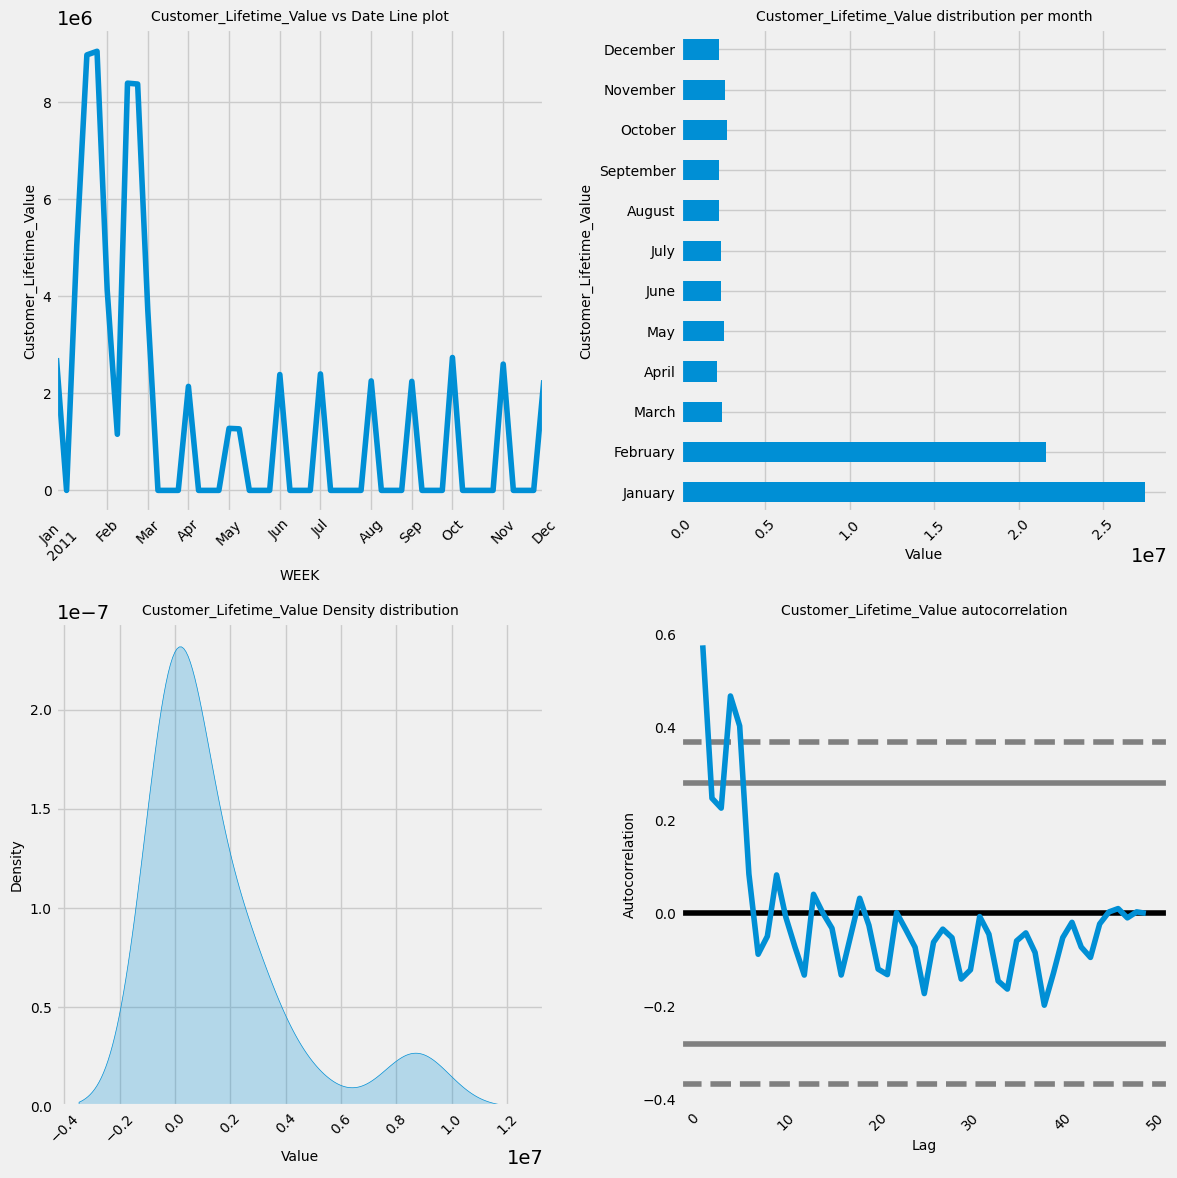

In [52]:
targetplot(df_series, var='Customer_Lifetime_Value')

### Decomposition

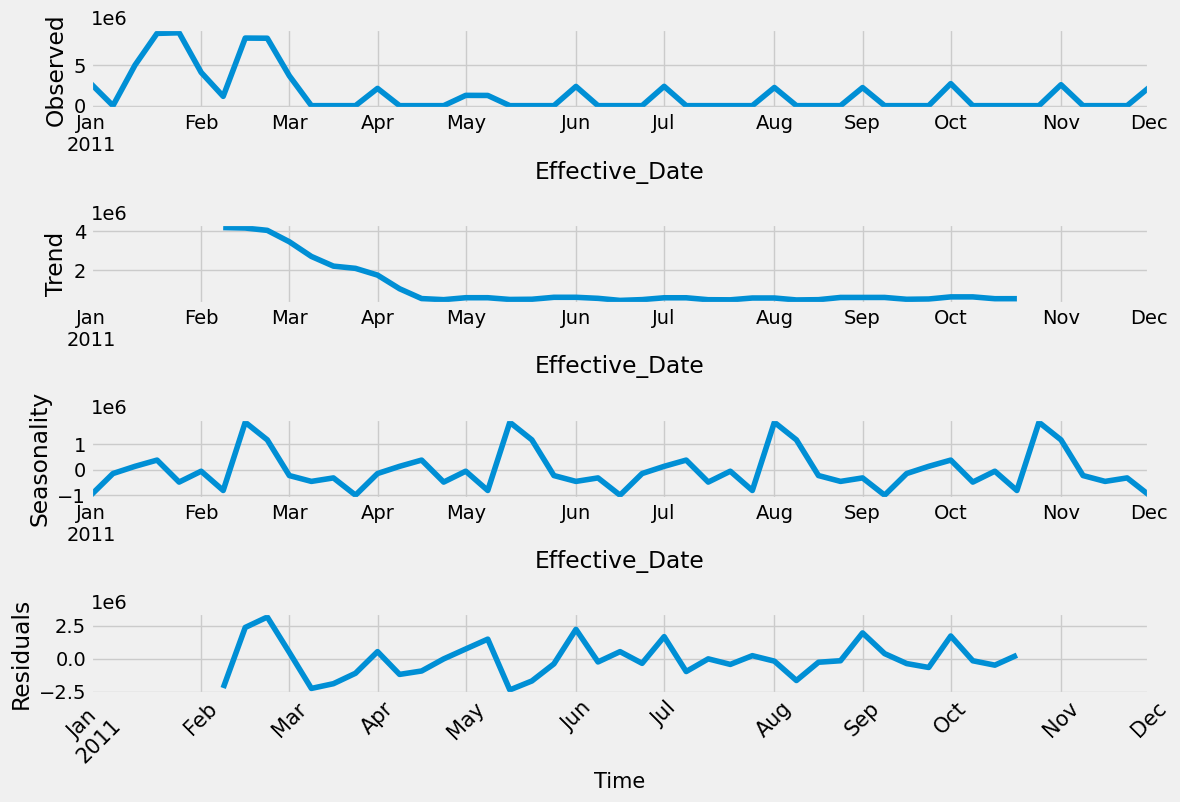

In [53]:
decomposition(data=df_series, var='Customer_Lifetime_Value', model='additive', period=12)

### Stationarity

In [54]:
ADF_test(df_series, var='Customer_Lifetime_Value')

ADF Statistic: -95.324364
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [55]:
# statistics of partitioned time series
stat_partitioned(df=df_series, var='Customer_Lifetime_Value')

mean1=8139.418330, mean2=7870.462620
variance1=49783485.738905, variance2=44590400.179983


In [56]:
# statistics of log partitioned time series
stat_log_partitioned(df=df_series, var='Customer_Lifetime_Value')

mean1=8.758978, mean2=8.738529
variance1=0.437475, variance2=0.414560


In [57]:
# statistics of box-cox partitioned time series
stat_boxcox_partitioned(df=df_series, var='Customer_Lifetime_Value', lmbda=0.005)

mean1=8.954553, mean2=8.933127
variance1=0.478594, variance2=0.453396


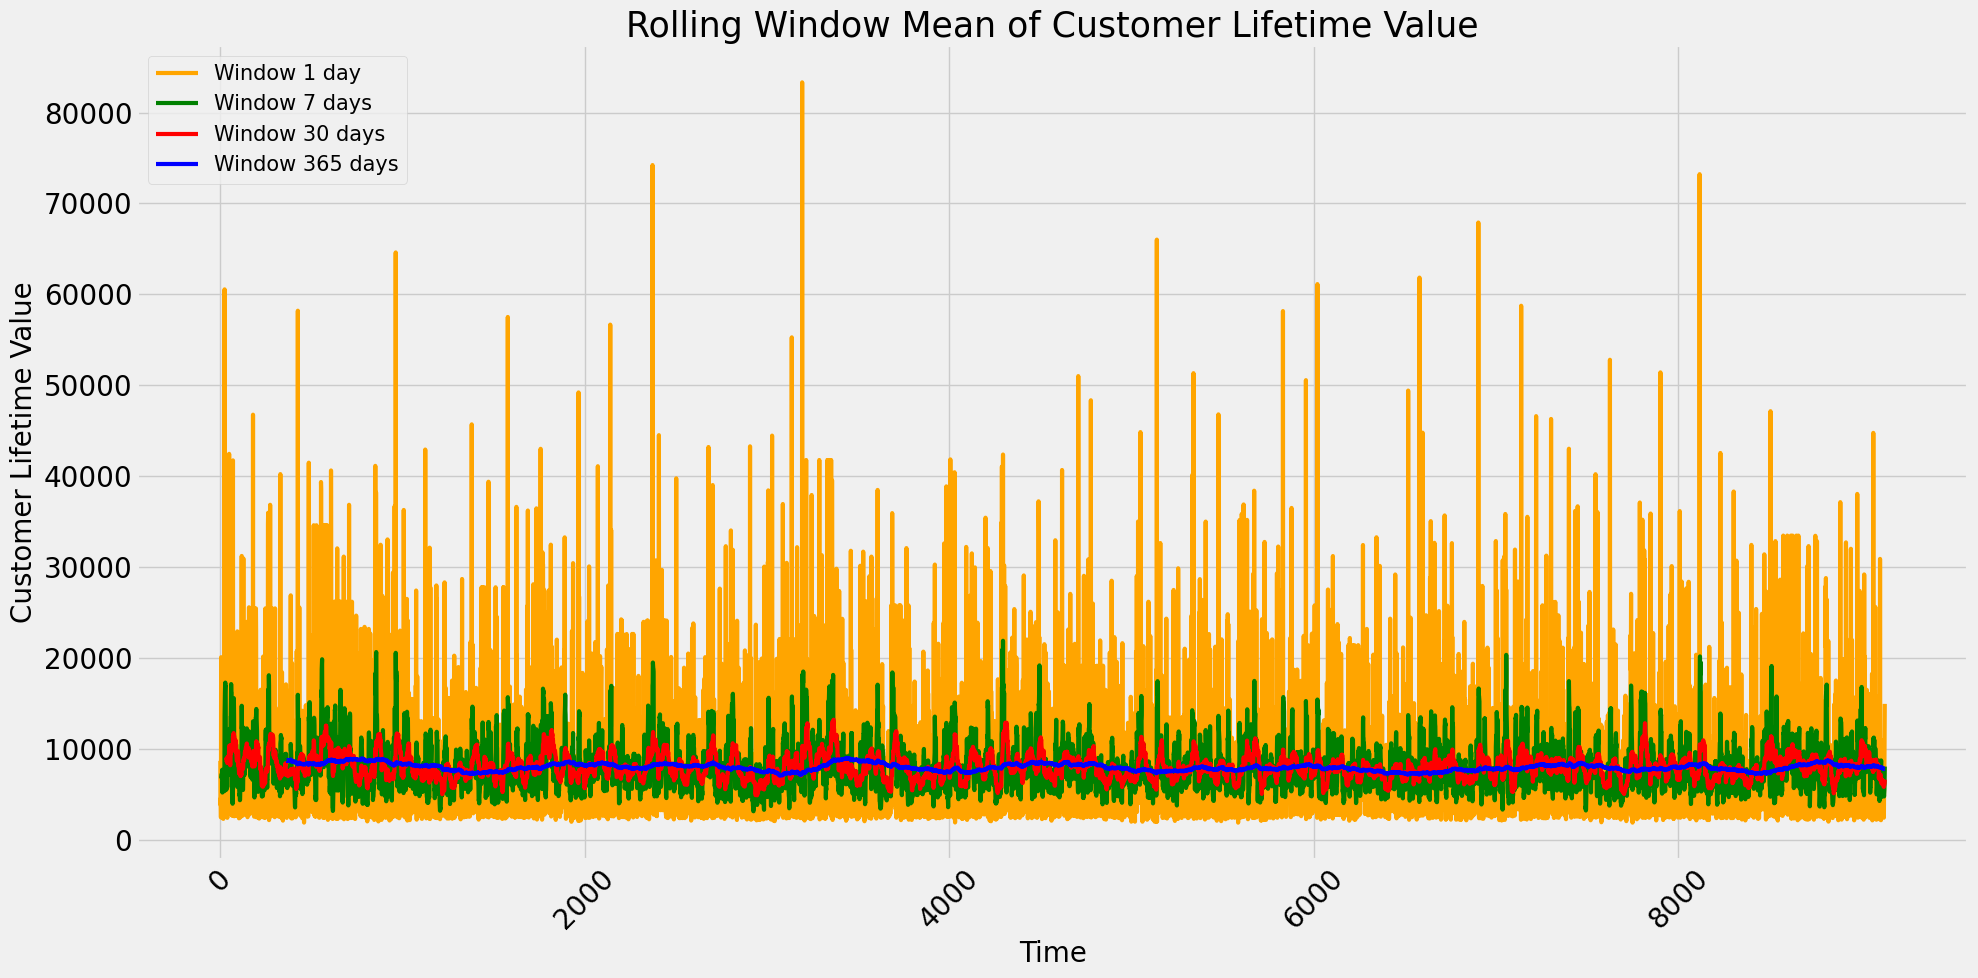

In [58]:
# Plot rolling window
plot_rolling_window(df=df_series)

### Categorical Analysis

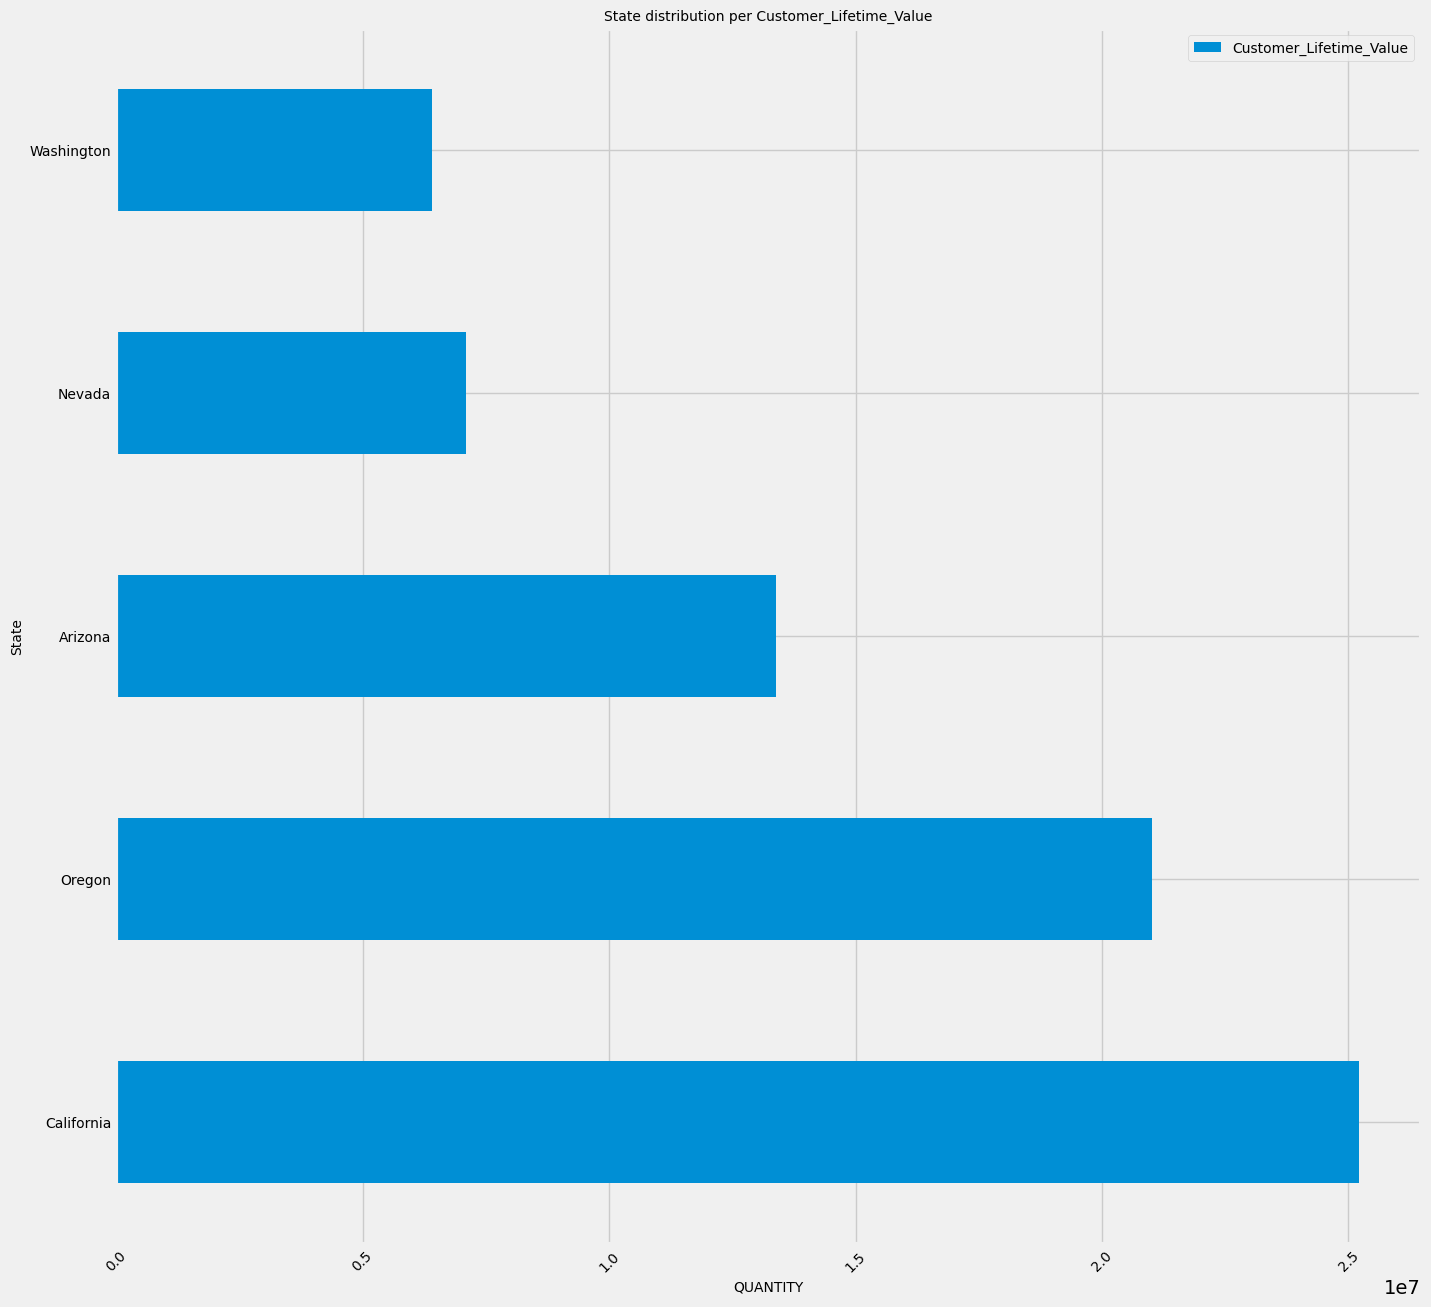

In [59]:
catplot(df_series, var_c='State', var_t='Customer_Lifetime_Value')

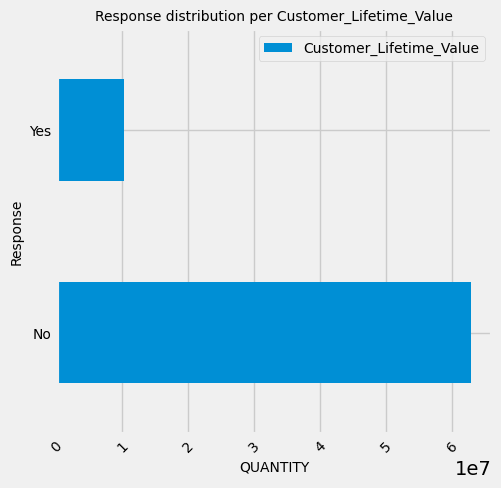

In [60]:
catplot(df_series, var_c='Response', var_t='Customer_Lifetime_Value')

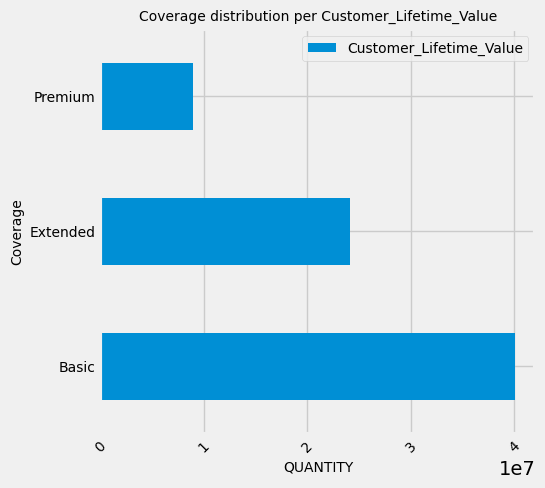

In [61]:
catplot(df_series, var_c='Coverage', var_t='Customer_Lifetime_Value')

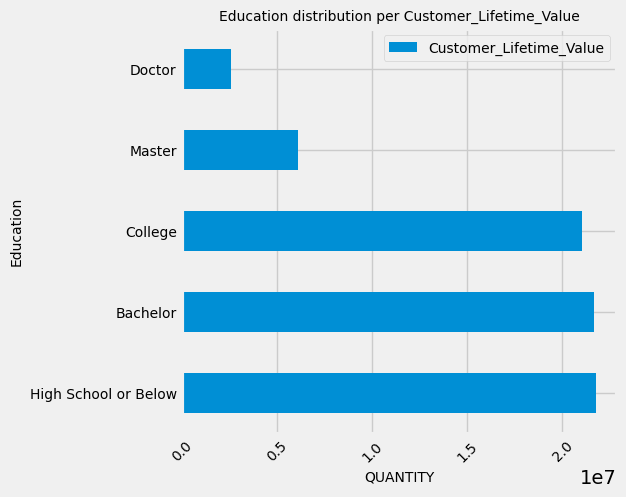

In [62]:
catplot(df_series, var_c='Education', var_t='Customer_Lifetime_Value')

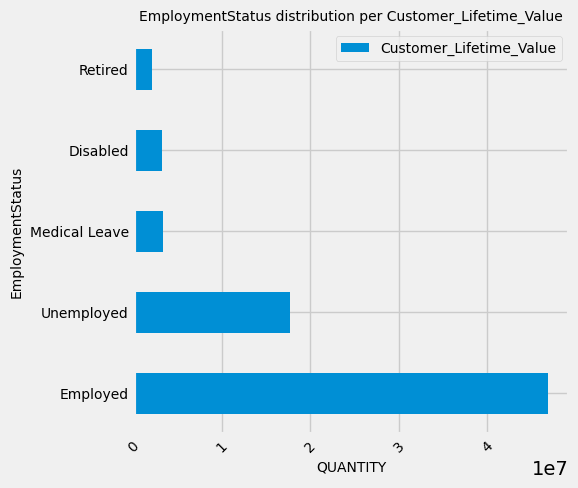

In [63]:
catplot(df_series, var_c='EmploymentStatus', var_t='Customer_Lifetime_Value')

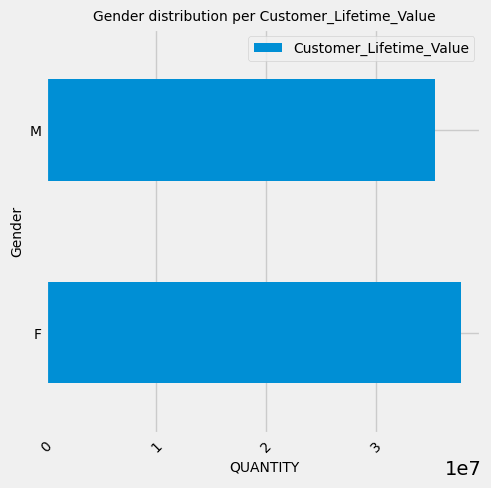

In [64]:
catplot(df_series, var_c='Gender', var_t='Customer_Lifetime_Value')

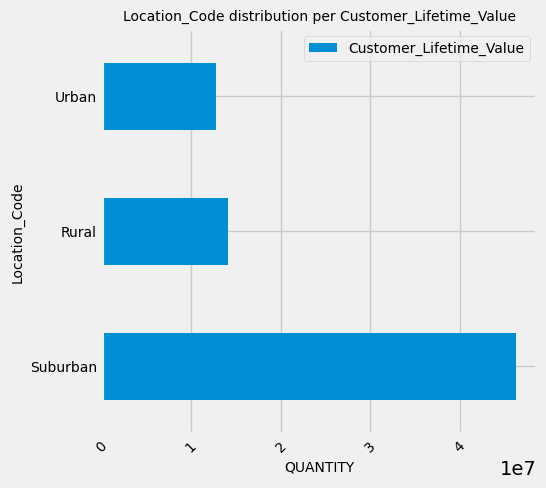

In [65]:
catplot(df_series, var_c='Location_Code', var_t='Customer_Lifetime_Value')

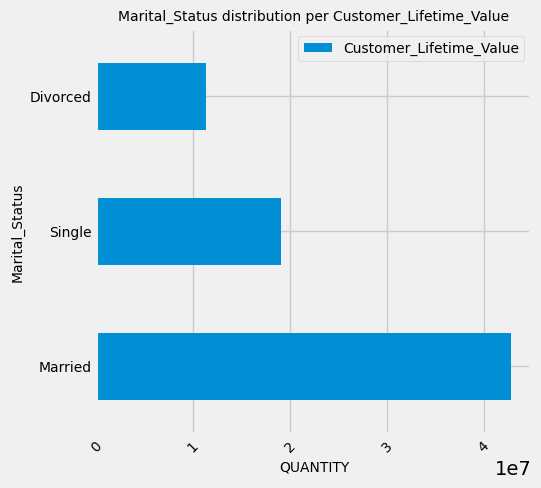

In [66]:
catplot(df_series, var_c='Marital_Status', var_t='Customer_Lifetime_Value')

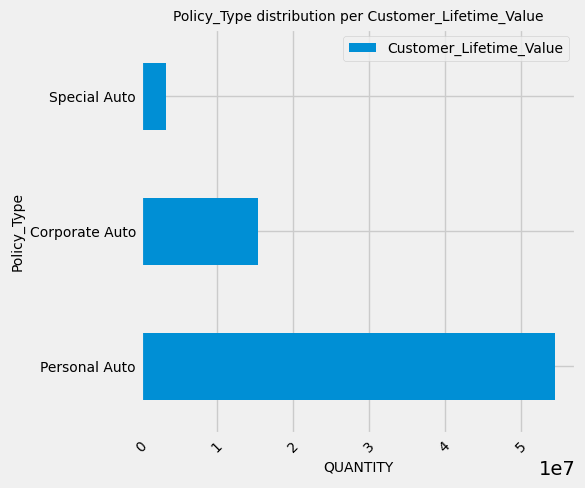

In [67]:
catplot(df_series, var_c='Policy_Type', var_t='Customer_Lifetime_Value')

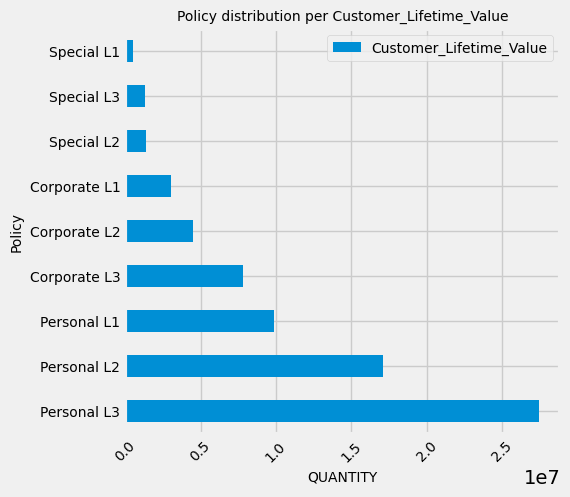

In [68]:
catplot(df_series, var_c='Policy', var_t='Customer_Lifetime_Value')

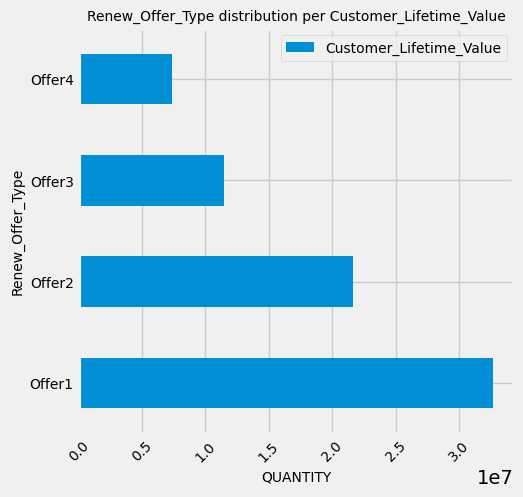

In [69]:
catplot(df_series, var_c='Renew_Offer_Type', var_t='Customer_Lifetime_Value')

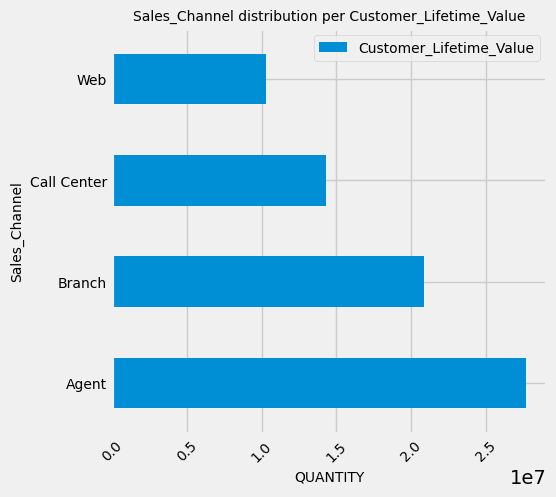

In [70]:
catplot(df_series, var_c='Sales_Channel', var_t='Customer_Lifetime_Value')

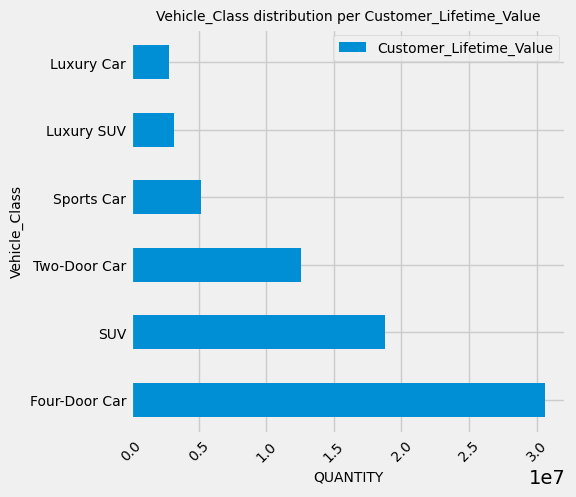

In [71]:
catplot(df_series, var_c='Vehicle_Class', var_t='Customer_Lifetime_Value')

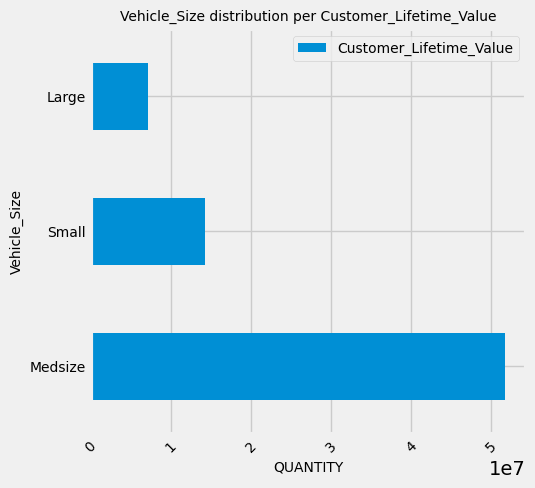

In [72]:
catplot(df_series, var_c='Vehicle_Size', var_t='Customer_Lifetime_Value')

### Numerical Analysis

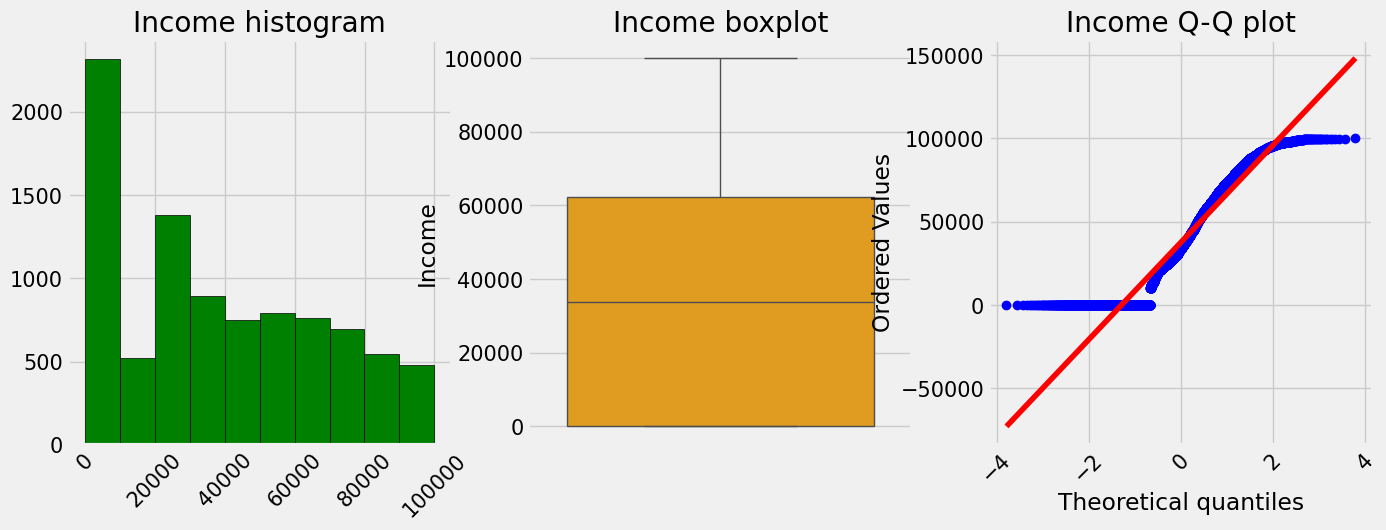

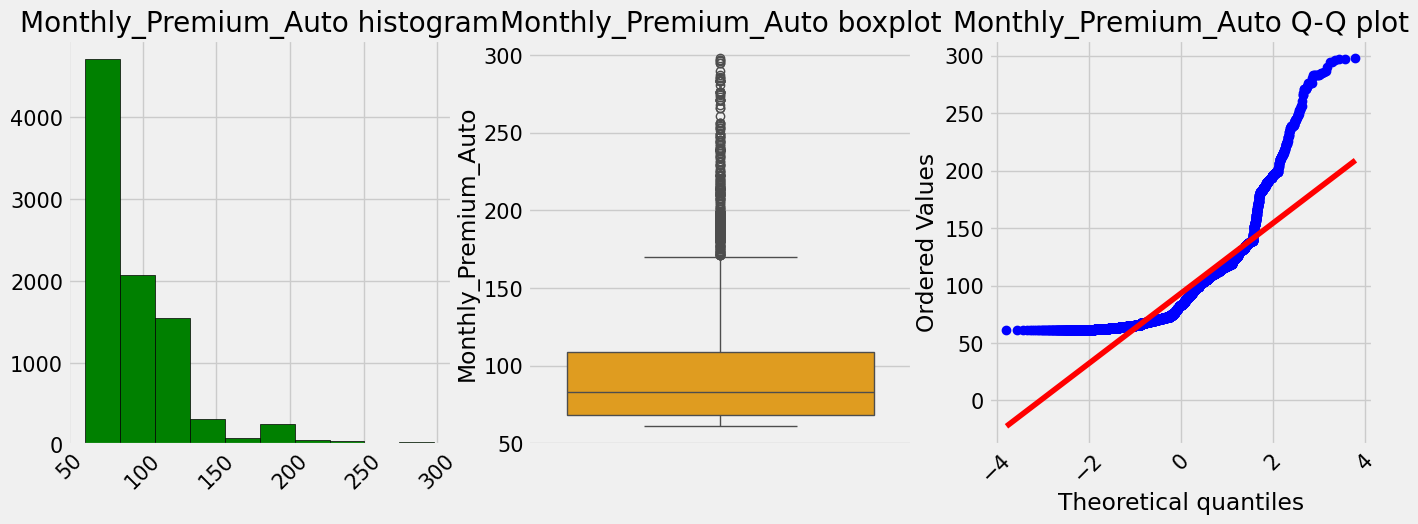

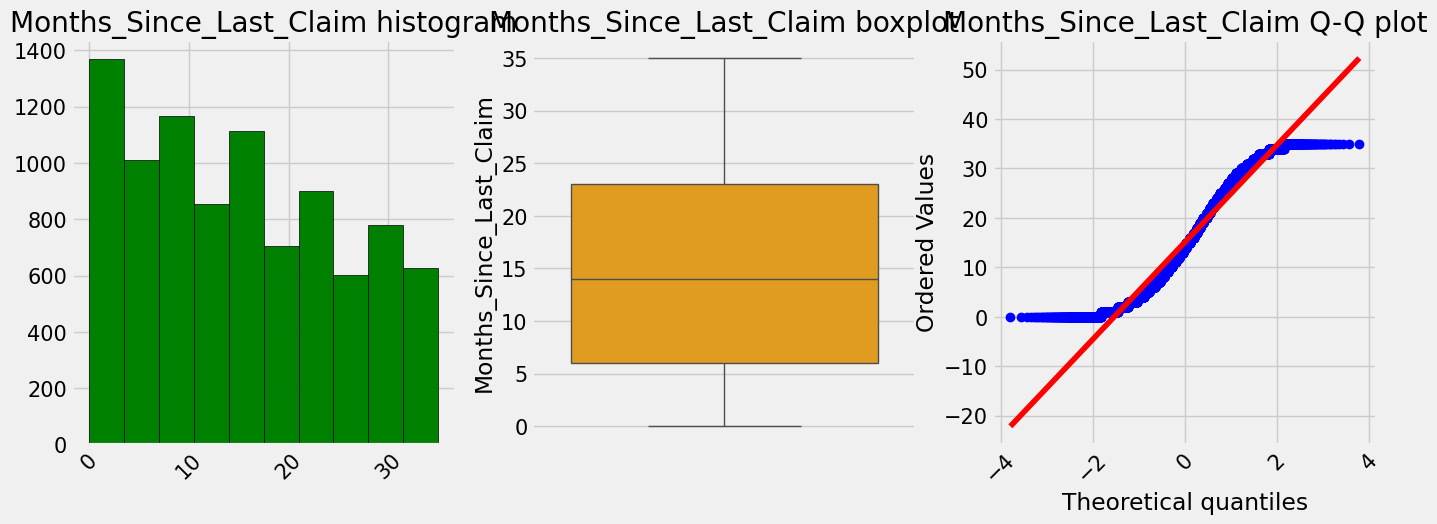

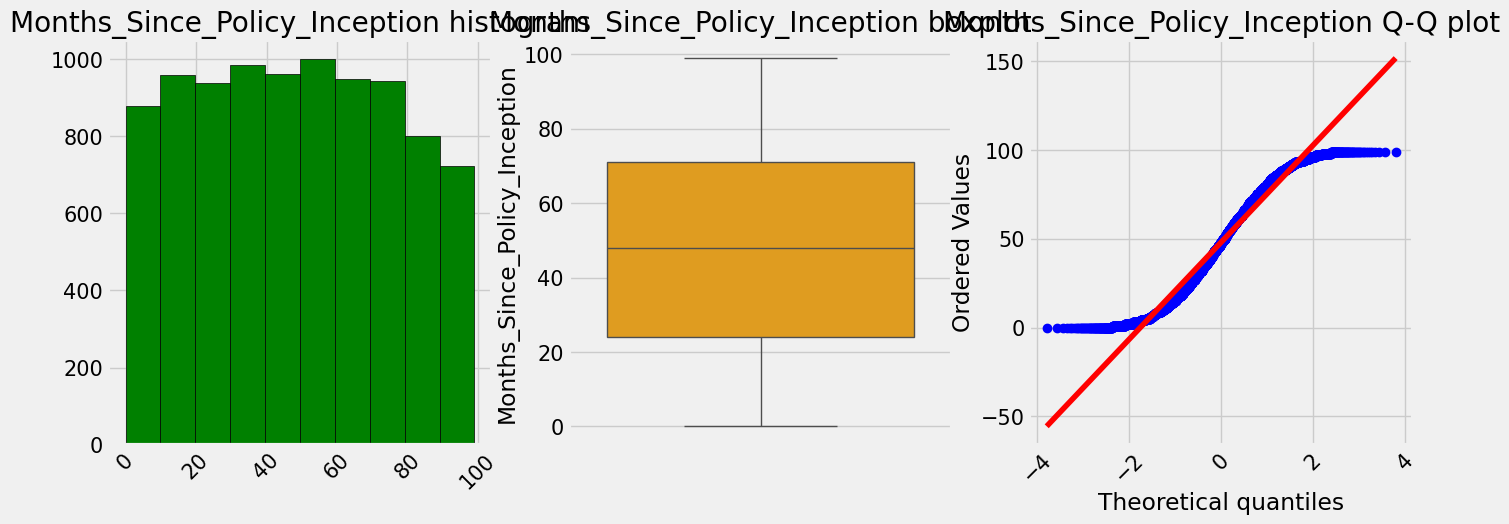

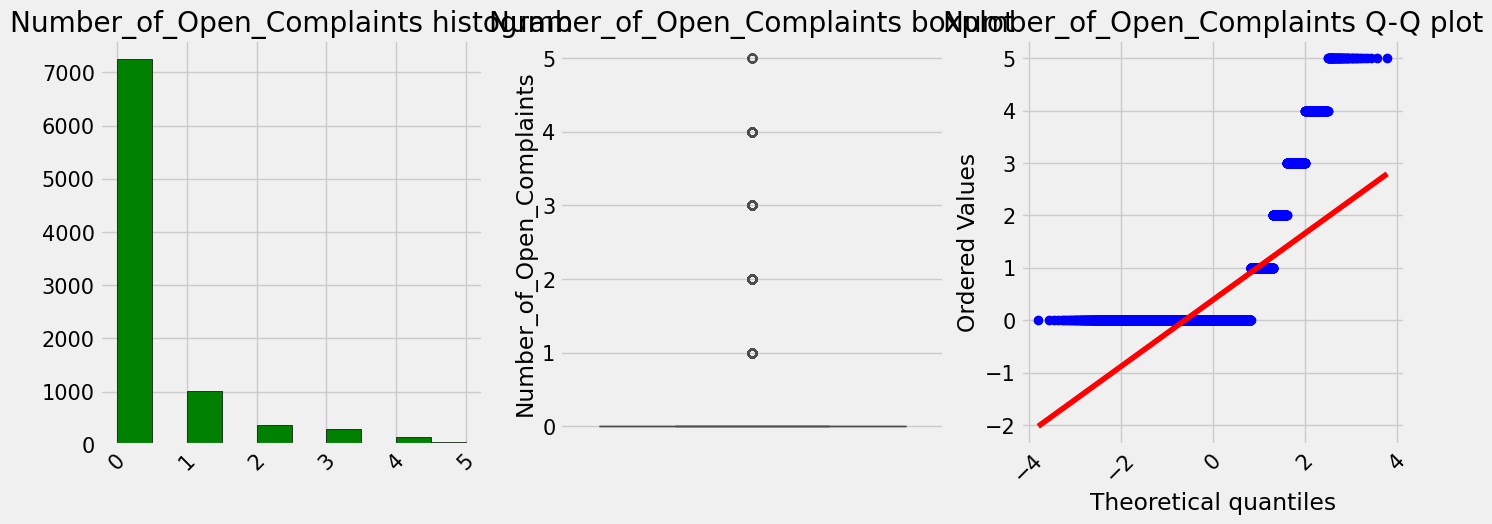

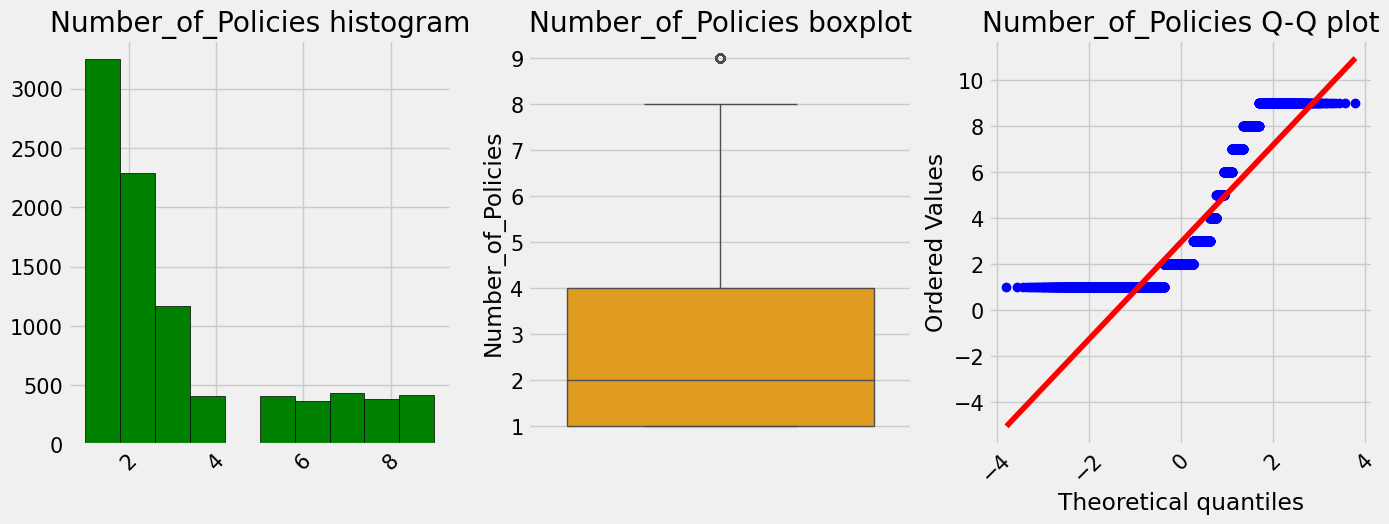

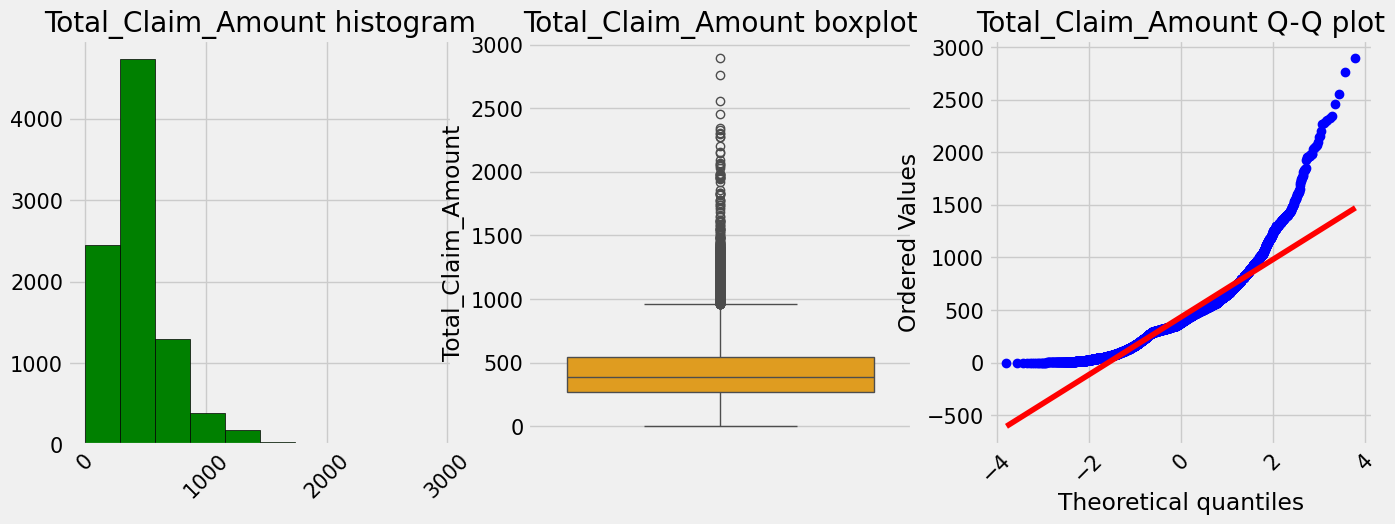

In [73]:
num_cols = [cname for cname in df_series.columns if
       df_series[cname].dtype in ['float64','int64']]
num = df_series[num_cols]

numplot(num, var='Income')
numplot(num, var='Monthly_Premium_Auto')
numplot(num, var='Months_Since_Last_Claim')
numplot(num, var='Months_Since_Policy_Inception')
numplot(num, var='Number_of_Open_Complaints')
numplot(num, var='Number_of_Policies')
numplot(num, var='Total_Claim_Amount')



Statistics=0.401, p=0.000
Sample does not look Gaussian (reject H0)


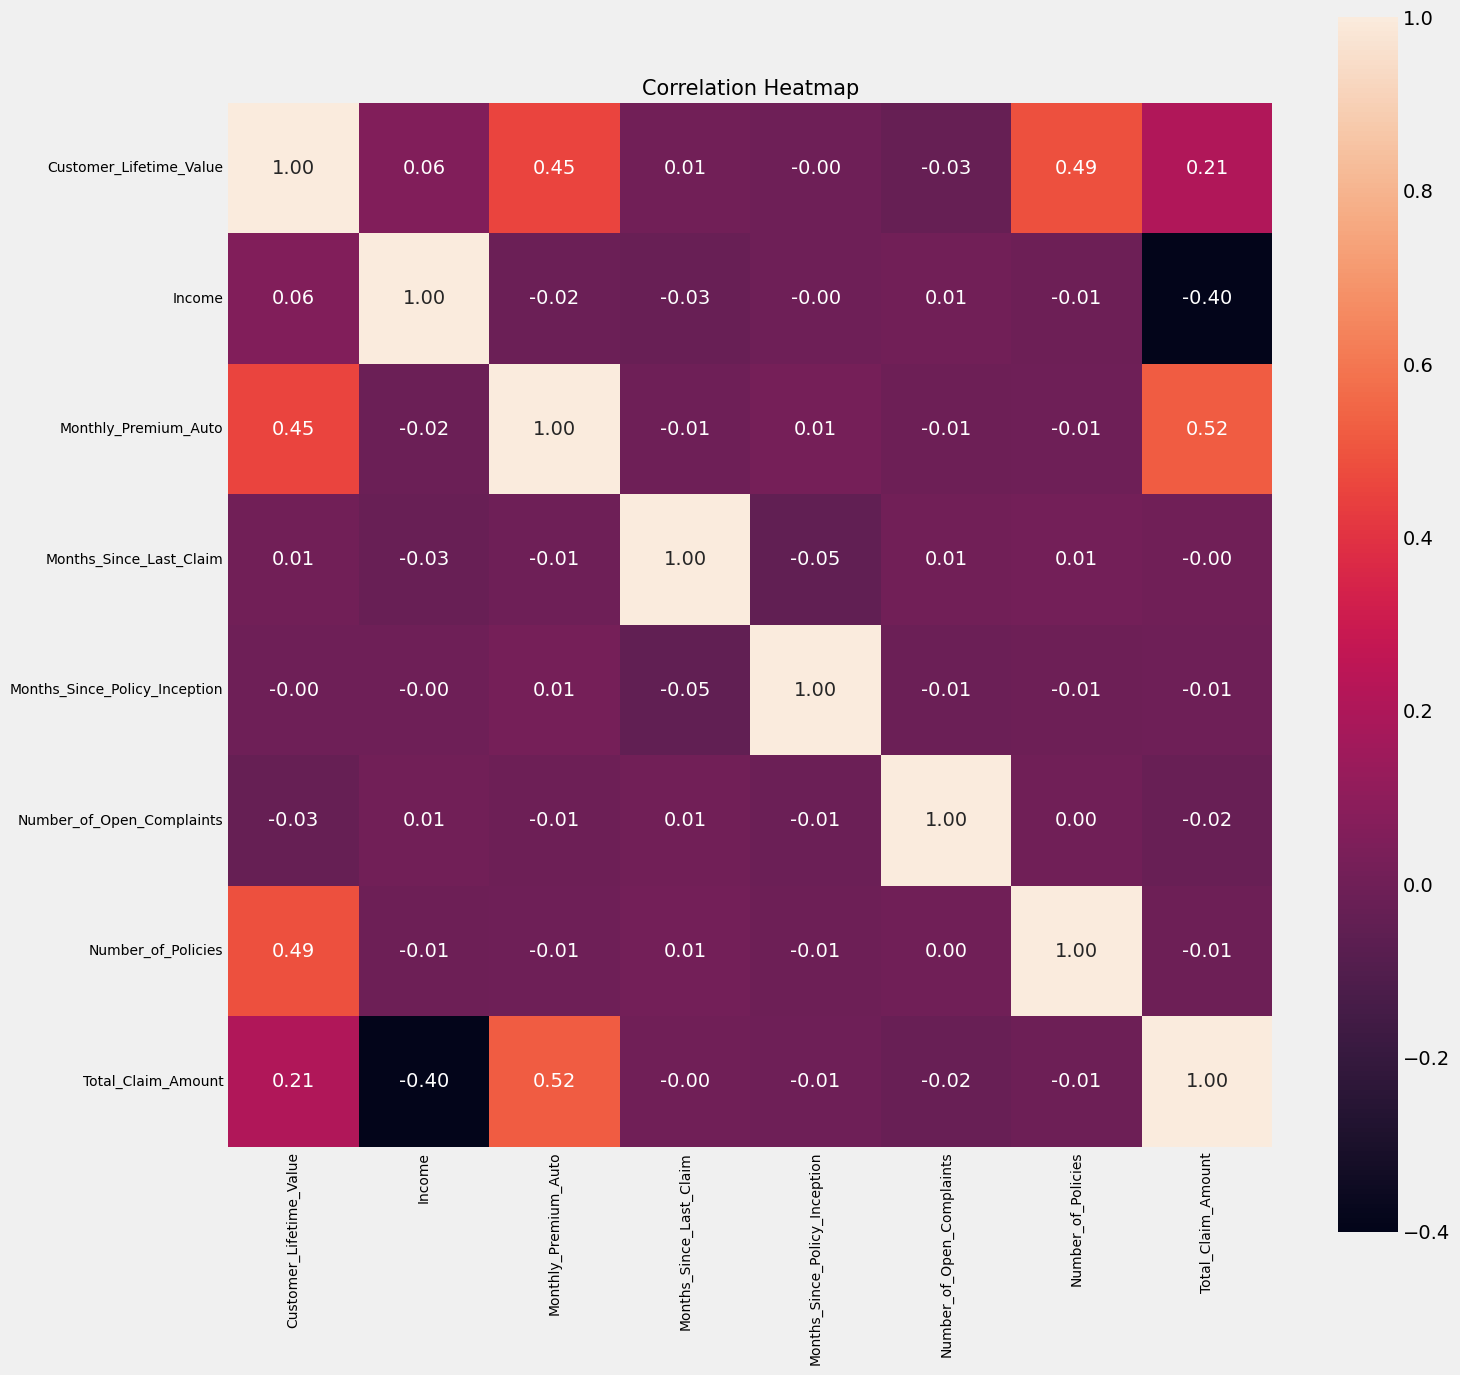

In [74]:
# correlation
corr_matrix_id = num
corr_method = check_normality(corr_matrix_id)
numheatmap(corr_matrix_id, corr_method)

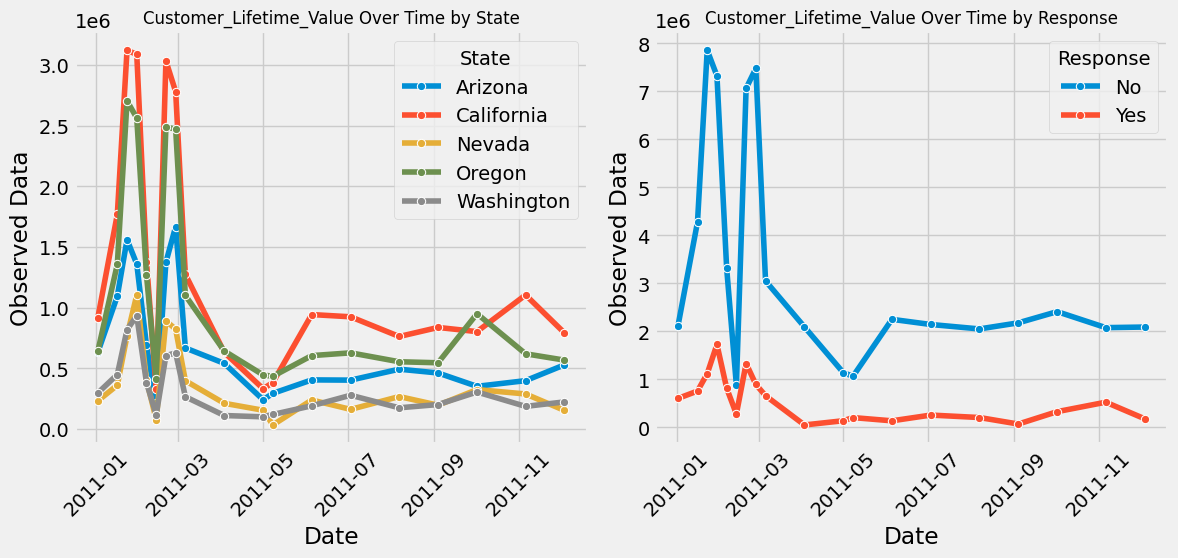

In [75]:
plot_multiple_categories(data=df_2, x='Effective_Date', y='Customer_Lifetime_Value',
                         categories=['State', 'Response'])

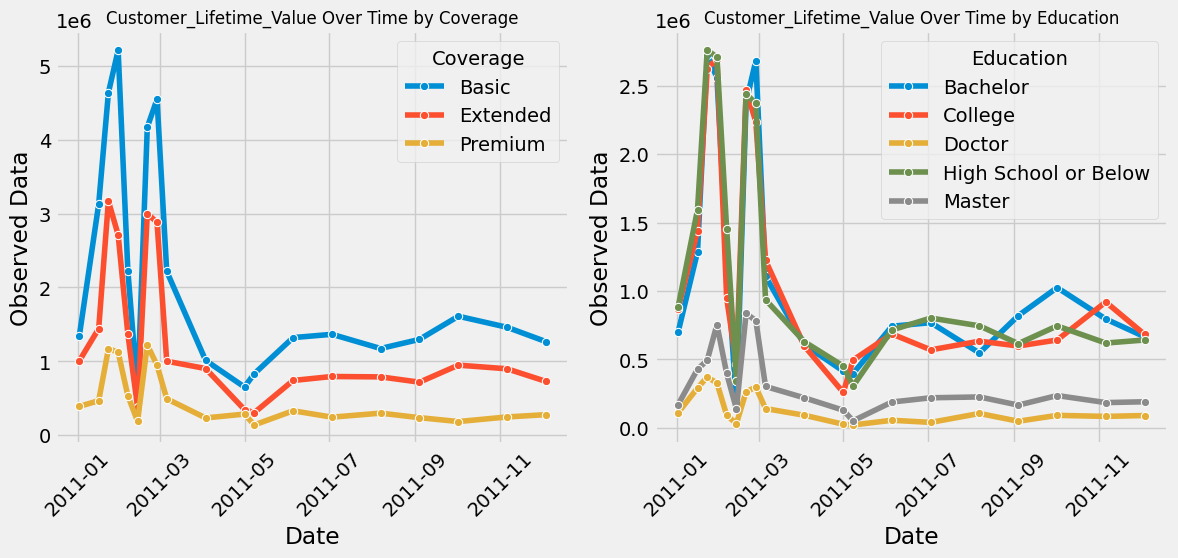

In [76]:
plot_multiple_categories(data=df_2, x='Effective_Date', y='Customer_Lifetime_Value',
                         categories=[ 'Coverage', 'Education'])

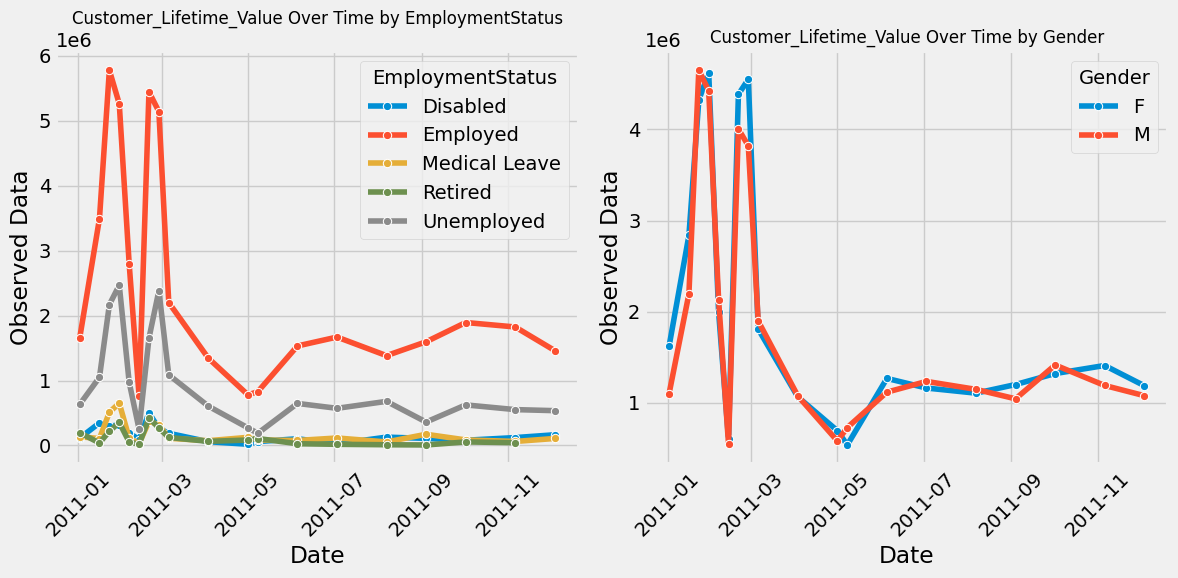

In [77]:
plot_multiple_categories(data=df_2, x='Effective_Date', y='Customer_Lifetime_Value',
                         categories=['EmploymentStatus', 'Gender'])

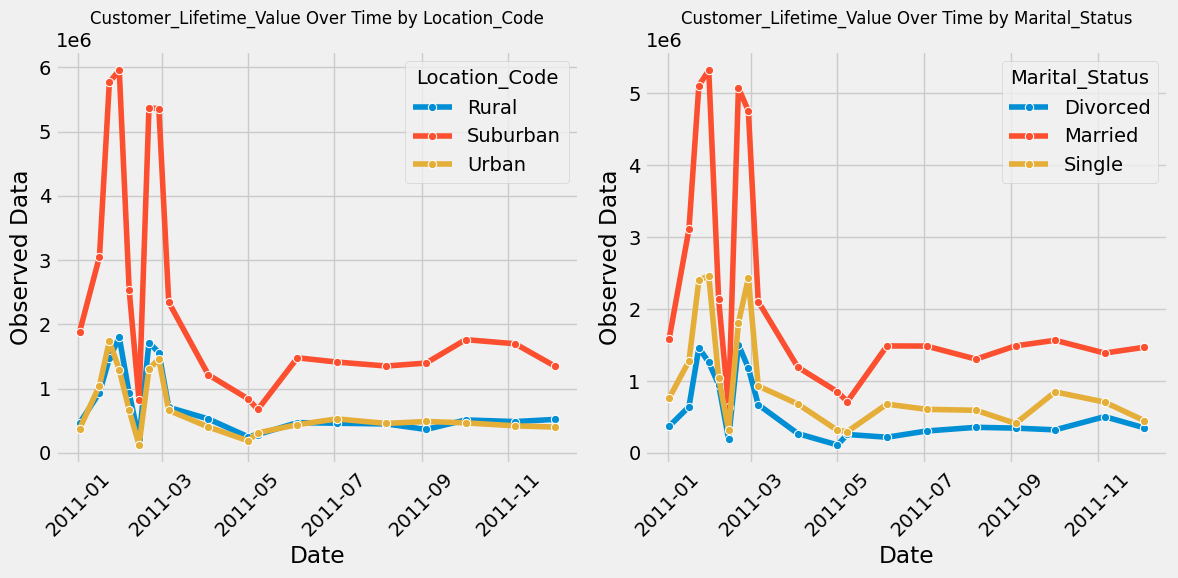

In [78]:
plot_multiple_categories(data=df_2, x='Effective_Date', y='Customer_Lifetime_Value',
                         categories=['Location_Code','Marital_Status'])

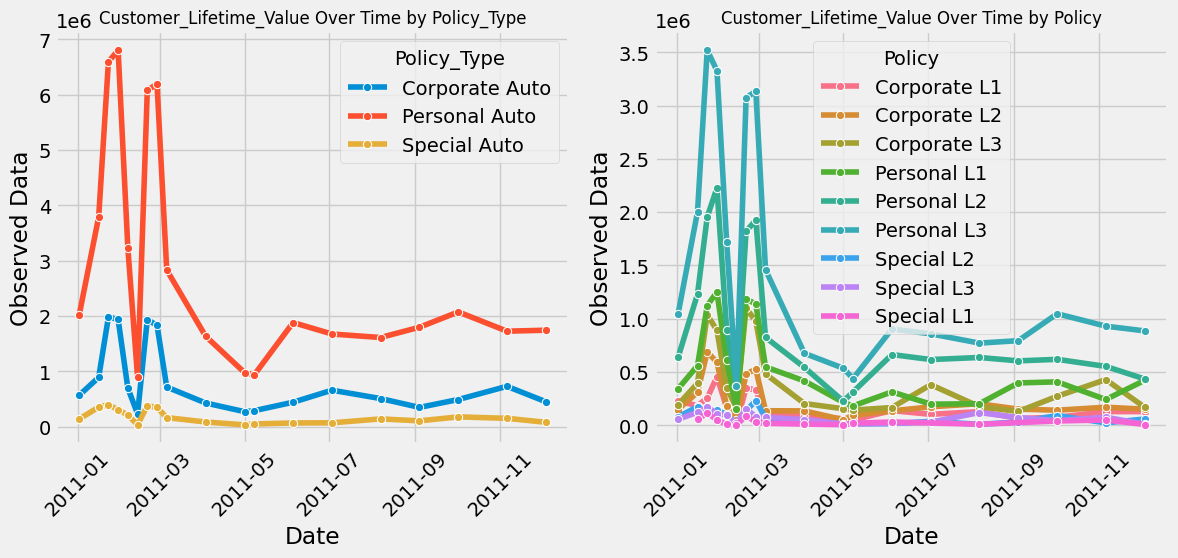

In [79]:
plot_multiple_categories(data=df_2, x='Effective_Date', y='Customer_Lifetime_Value',
                         categories=['Policy_Type','Policy'])

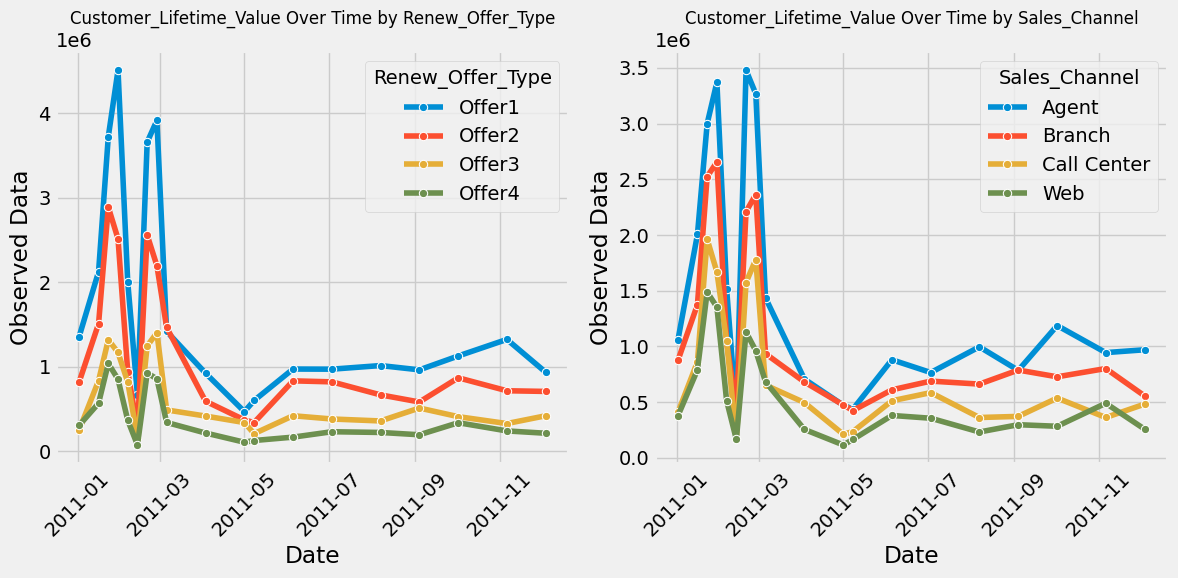

In [80]:
plot_multiple_categories(data=df_2, x='Effective_Date', y='Customer_Lifetime_Value',
                         categories=['Renew_Offer_Type','Sales_Channel'])

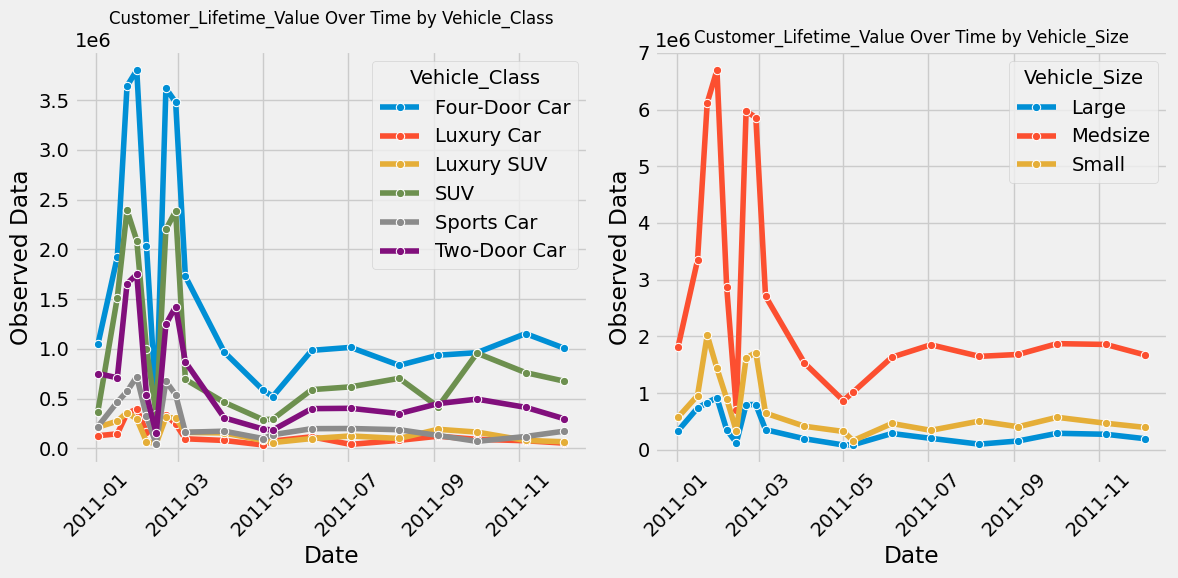

In [81]:
plot_multiple_categories(data=df_2, x='Effective_Date', y='Customer_Lifetime_Value',
                         categories=['Vehicle_Class','Vehicle_Size'])

### References

https://mapie.readthedocs.io/en/latest/index.html

https://github.com/PacktPublishing/Practical-Guide-to-Applied-Conformal-Prediction

https://christophmolnar.com/books/conformal-prediction/

https://www.kaggle.com/datasets/debajyotipodder/co2-emission-by-vehicles